# Imports

In [1]:
import os
import json
import pickle
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from utils import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [3]:
# define a function to save the feature vector dictionary to disk
def load_feature_data(vectors_filepath, names_filepath):
    
    # extract the JSON file from the tar.gz file
    with tarfile.open(vectors_filepath, 'r:gz') as tar:
        tar.extractall()
        json_filename = tar.getnames()[0]  # assuming only one file in the archive
    
    # load the JSON file and convert Python lists back to numpy arrays
    with open(json_filename, 'r') as f:
        feature_vectors_dict = json.load(f)
    
    feature_vectors = {}
    for class_name, vectors in feature_vectors_dict.items():
        feature_vectors[class_name] = [np.array(vector) for vector in vectors]
    
    # remove the extracted JSON file
    os.remove(json_filename)
    
    # load feature names
    with open(names_filepath, 'rb') as f:
        feature_names = pickle.load(f)
        
    return feature_vectors, feature_names

In [4]:
# define a function to visualize the PCA elbow plot
def evaluate_pca(pca):
    
    # compute the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # plot the elbow plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative % of Variation Explained')
    plt.title('Principal Component Elbow Plot')
    plt.grid(True)
    
    # find the location of inflection point
    # NOTE: this is used to determine the best number of PC's
    diff = np.diff(cumulative_variance)
    inflection_point = np.argmax(diff < np.mean(diff))
    plt.axvline(x=inflection_point + 1, color='r', linestyle='--')
    plt.axhline(y=cumulative_variance[inflection_point], color='r', linestyle='--')
    
    # add label to indicate inflection point
    plt.text(inflection_point + 50, cumulative_variance[inflection_point] - .2,
            f"n_components={inflection_point + 1}\ncum_%_variation={cumulative_variance[inflection_point]*100:.2f}%", color='r', fontsize=10)

    plt.show()
    
    return inflection_point + 1
    

In [5]:
# define a function to display the main features that contribute to a set of top PC's
def display_loadings(pca, n_pc=5, n_features=10):
    
    # extract top principal components
    top_components = pca.components_[:n_pc]

    # create dataframes for top principal components
    for i, component in enumerate(top_components):
        loading_scores = pd.DataFrame({'feature_name': feature_names, 'loading_score': component})
        loading_scores = loading_scores.sort_values(by='loading_score', ascending=False).head(n_features)
        print(f"Top {n_features} features for Principal Component {i + 1}:")
        display(loading_scores)

# Load data

In [6]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

In [7]:
# load feature data from disk
feature_vectors_train, feature_names = load_feature_data("../data/processed/feature_vectors_train.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_val, feature_names = load_feature_data("../data/processed/feature_vectors_val.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_test, feature_names = load_feature_data("../data/processed/feature_vectors_test.tar.gz", "../data/processed/feature_names.pkl")


In [8]:
# inspections
print(type(feature_vectors_train))
print(feature_vectors_train.keys())
print(type(feature_vectors_train['beach']))
print(len(feature_vectors_train['beach']))
print(type(feature_vectors_train['beach'][0]))
print(len(feature_vectors_train['beach'][0]))
print(feature_vectors_train['beach'][0])

<class 'dict'>
dict_keys(['parking_space', 'beach', 'forest', 'overpass', 'river', 'dense_residential', 'swimming_pool', 'chaparral', 'freeway', 'harbor'])
<class 'list'>
479
<class 'numpy.ndarray'>
1392
[113.95576477 127.46353149 119.84751892 ...   4.           4.
   1.        ]


# Transform data

In [9]:
# flatten feature vectors and prepare data for PCA
X = []
for class_name in classes:
    X.extend(feature_vectors_train[class_name])
X = np.array(X)
print(X.shape)

# standardize data
features_scaler = StandardScaler()
X = features_scaler.fit_transform(X)

# save the standardization scaler to disk
with open("../data/processed/features_scaler.pkl", 'wb') as f:
    pickle.dump(features_scaler, f)

(4799, 1392)


# Principal Component Analysis

In [10]:
# perform PCA
pca_model = PCA()
pca_model.fit(X)

PCA()

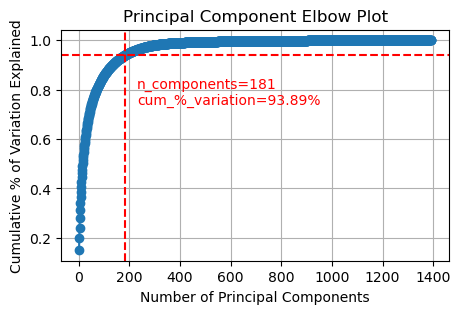

In [11]:
n_pc_components = evaluate_pca(pca_model)

In [12]:
display_loadings(pca_model, n_pc=5, n_features=5)

Top 5 features for Principal Component 1:


,feature_name,loading_score
1272,hog_1206,0.039262
1056,hog_990,0.038973
1236,hog_1170,0.038029
1260,hog_1194,0.038009
1240,hog_1174,0.037811


Top 5 features for Principal Component 2:


,feature_name,loading_score
662,hog_596,0.063820
878,hog_812,0.059598
674,hog_608,0.059094
866,hog_800,0.058416
650,hog_584,0.057042


Top 5 features for Principal Component 3:


,feature_name,loading_score
186,hog_120,0.053110
390,hog_324,0.050915
666,hog_600,0.047324
634,hog_568,0.046859
402,hog_336,0.046576


Top 5 features for Principal Component 4:


,feature_name,loading_score
1364,homogeneity_mean,0.064161
821,hog_755,0.060660
857,hog_791,0.056000
856,hog_790,0.055796
820,hog_754,0.053311


Top 5 features for Principal Component 5:


,feature_name,loading_score
785,hog_719,0.066942
393,hog_327,0.066507
884,hog_818,0.066025
784,hog_718,0.065792
885,hog_819,0.064362


In [13]:
# re-compute pca model with optimum number of PC's
pca_model = PCA(n_components=n_pc_components)
pca_model.fit(X)

# save the pca model to disk
with open("../data/processed/pca_model.pkl", 'wb') as f:
    pickle.dump(pca_model, f)

# tSNE Visualization

In [15]:
# load class color map from pickle file
with open('../data/processed/eda_class_color_mapping.pkl', 'rb') as f:
    class_color_mapping= pickle.load(f)

In [18]:
# compress data based on PCA model
pc_vectors_train = pca_model.transform(X)

# initialize tSNE with desired parameters
tsne = TSNE(n_components=2)

# fit and transform the data using t-SNE
tsne_data = tsne.fit_transform(pc_vectors_train)

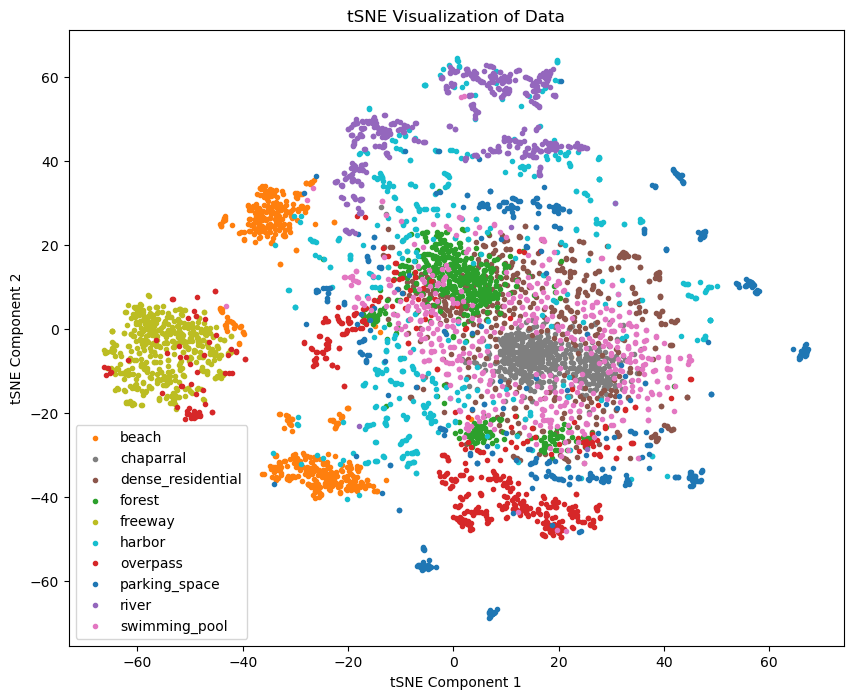

In [19]:
# visualize clustering of train pc's with color-coded classes using loaded class color mapping
plt.figure(figsize=(10, 8))
start_idx = 0
for class_name in classes:
    end_idx = start_idx + len(feature_vectors_train[class_name])
    class_color = class_color_mapping[class_name]
    plt.scatter(tsne_data[start_idx:end_idx, 0], tsne_data[start_idx:end_idx, 1], marker='.', color=class_color, label=class_name)
    start_idx = end_idx
plt.title('tSNE Visualization of Data')
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.legend()
plt.show()
